In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


In [2]:
ppx = pd.read_csv('poreplex/VeroInf24h/sequencing_summary.txt', low_memory=False, sep='\t')

In [3]:
orfcolors = pd.read_csv('colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()
orfcolors

{'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

In [4]:
orfcolors['gRNA'] = orfcolors['ORF1a']

In [5]:
trmapping = \
pd.read_csv('junctions/VeroInf24h.canonical_swithing_annotations.txt.gz', compression='gzip',
            names=['read_id', 'transcript'], sep='\t')

orf1ab_sup = pd.read_csv('junctions/VeroInf24h.subset-ORF1ab.readids', names=['read_id'])
orf1ab_sup['transcript'] = 'gRNA'
trmapping = pd.concat([trmapping, orf1ab_sup])

In [6]:
trmapped_ppx = pd.merge(trmapping, ppx, left_on='read_id', right_on='read_id')
trmapped_ppx.head()

,read_id,transcript,filename,run_id,channel,start_time,duration,num_events,sequence_length,mean_qscore,sample_id,status,label,polya_dwell
0,0000001d-eb54-4f34-8523-908a69ba6081,ORF7a,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,468,63860.210,91960,9156,2606,11.213770,vero-infected,okay,pass,0.2377
1,00001045-6895-453f-99ba-f6b5322aa80f,ORF6,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,512,44322.987,104760,10435,2956,10.380243,vero-infected,okay,pass,0.2407
2,00003adc-d8db-4d8b-b9ae-079f69fd492b,N,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,442,1438.137,66395,6123,1621,11.422580,vero-infected,okay,pass,0.4914
3,000079c0-a374-4f53-928f-da7b8e3d5a82,N,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,507,31234.992,71270,6990,1508,8.719546,vero-infected,okay,pass,NaN
4,0001620b-2986-4f96-9c55-2efb35ee8f04,ORF8,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,214,13422.660,74683,6985,1981,11.470112,vero-infected,okay,pass,0.3997


In [7]:
import sys
sys.path.append('/blaze/hyeshik/nest/tink/p/tailseeker')
from tailseeker import plotutils

Text(55.347222222222214, 0.5, 'Cumulative fraction')

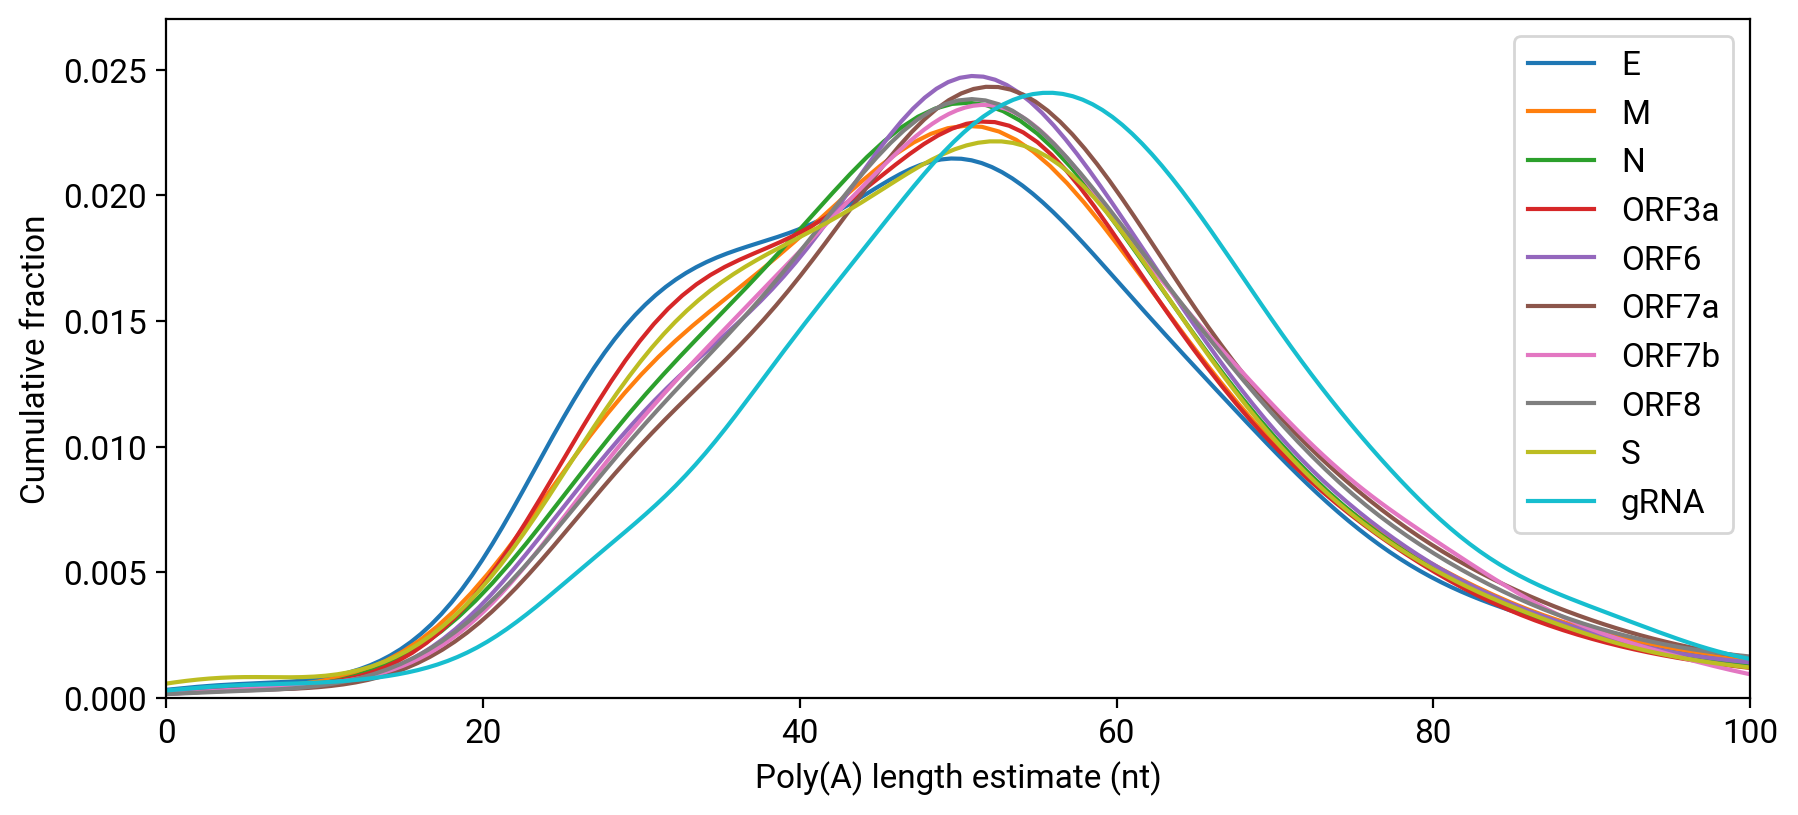

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

for trname, grp in trmapped_ppx.groupby('transcript'):
    (grp['polya_dwell'].dropna() * 105).plot.kde(ax=ax, label=trname, bw_method=0.2)

plt.tight_layout()
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.027)
ax.legend(loc='best')
ax.set_xlabel('Poly(A) length estimate (nt)')
ax.set_ylabel('Cumulative fraction')

# Host transcripts?

In [24]:
!samtools view -F 4 alignments/VeroInf24h.genome.sorted.bam | cut -f1,3 | grep -v chrSCV > tmp/non-viral-transcripts.ids

In [25]:
!wc -l tmp/non-viral-transcripts.ids

409916 tmp/non-viral-transcripts.ids


In [27]:
!grep 'chrRDN' tmp/non-viral-transcripts.ids|cut -f1|sort|uniq > tmp/non-viral-transcripts-rDNA.readids

In [28]:
!grep 'chrRCS' tmp/non-viral-transcripts.ids|cut -f1|sort|uniq > tmp/non-viral-transcripts-RCS.readids

In [35]:
!grep 'MT' tmp/non-viral-transcripts.ids|cut -f1|sort|uniq > tmp/non-viral-transcripts-MT.readids

In [30]:
!grep '	[0-9]*$' tmp/non-viral-transcripts.ids|cut -f1|sort|uniq > tmp/non-viral-transcripts-genomeenc.readids

In [9]:
reads_MT = pd.read_csv('tmp/non-viral-transcripts-MT.readids', names=['read_id'])
reads_RCS = pd.read_csv('tmp/non-viral-transcripts-RCS.readids', names=['read_id'])
reads_RDN = pd.read_csv('tmp/non-viral-transcripts-rDNA.readids', names=['read_id'])
reads_G = pd.read_csv('tmp/non-viral-transcripts-genomeenc.readids', names=['read_id'])

In [10]:
reads_MT['transcript'] = 'MT'
reads_RCS['transcript'] = 'RCS'
reads_RDN['transcript'] = 'rDNA'
reads_G['transcript'] = 'genomic'

In [11]:
hostreads = pd.concat([
    reads_MT,
    reads_RCS,
    reads_RDN,
    reads_G
])

In [12]:
hNv = pd.concat([hostreads, trmapping])

In [13]:
hNv_ppx = pd.merge(hNv, ppx, left_on='read_id', right_on='read_id')
hNv_ppx.head()

,read_id,transcript,filename,run_id,channel,start_time,duration,num_events,sequence_length,mean_qscore,sample_id,status,label,polya_dwell
0,00000b78-97b7-41cb-84a6-b8d9398eaf53,MT,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,62,26618.060,49856,4945,1223,9.795993,vero-infected,okay,pass,0.5272
1,000140a9-d91f-4eca-9593-d3baea094e5d,MT,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,216,28759.265,30647,3016,773,9.938125,vero-infected,okay,pass,0.6245
2,00018e58-9485-462c-bd93-7a8a9ed72180,MT,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,238,18542.815,44216,4314,788,8.898804,vero-infected,okay,pass,0.2546
3,00029e84-c073-487b-85b8-cc1137d9a4e9,MT,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,254,45173.795,42349,3843,743,8.326400,vero-infected,okay,pass,0.6052
4,000314a4-a272-4287-b483-efbc26b1f4ea,MT,20200222_0650_MN26136_FAN04901_ada1e2bf/fast5/...,90bfe2e3c6c56327d64dd1e78bc48842ade46dc7,510,23343.050,26360,1671,325,13.072891,vero-infected,okay,pass,0.5999


Text(64.72222222222221, 0.5, 'Cumulative fraction')

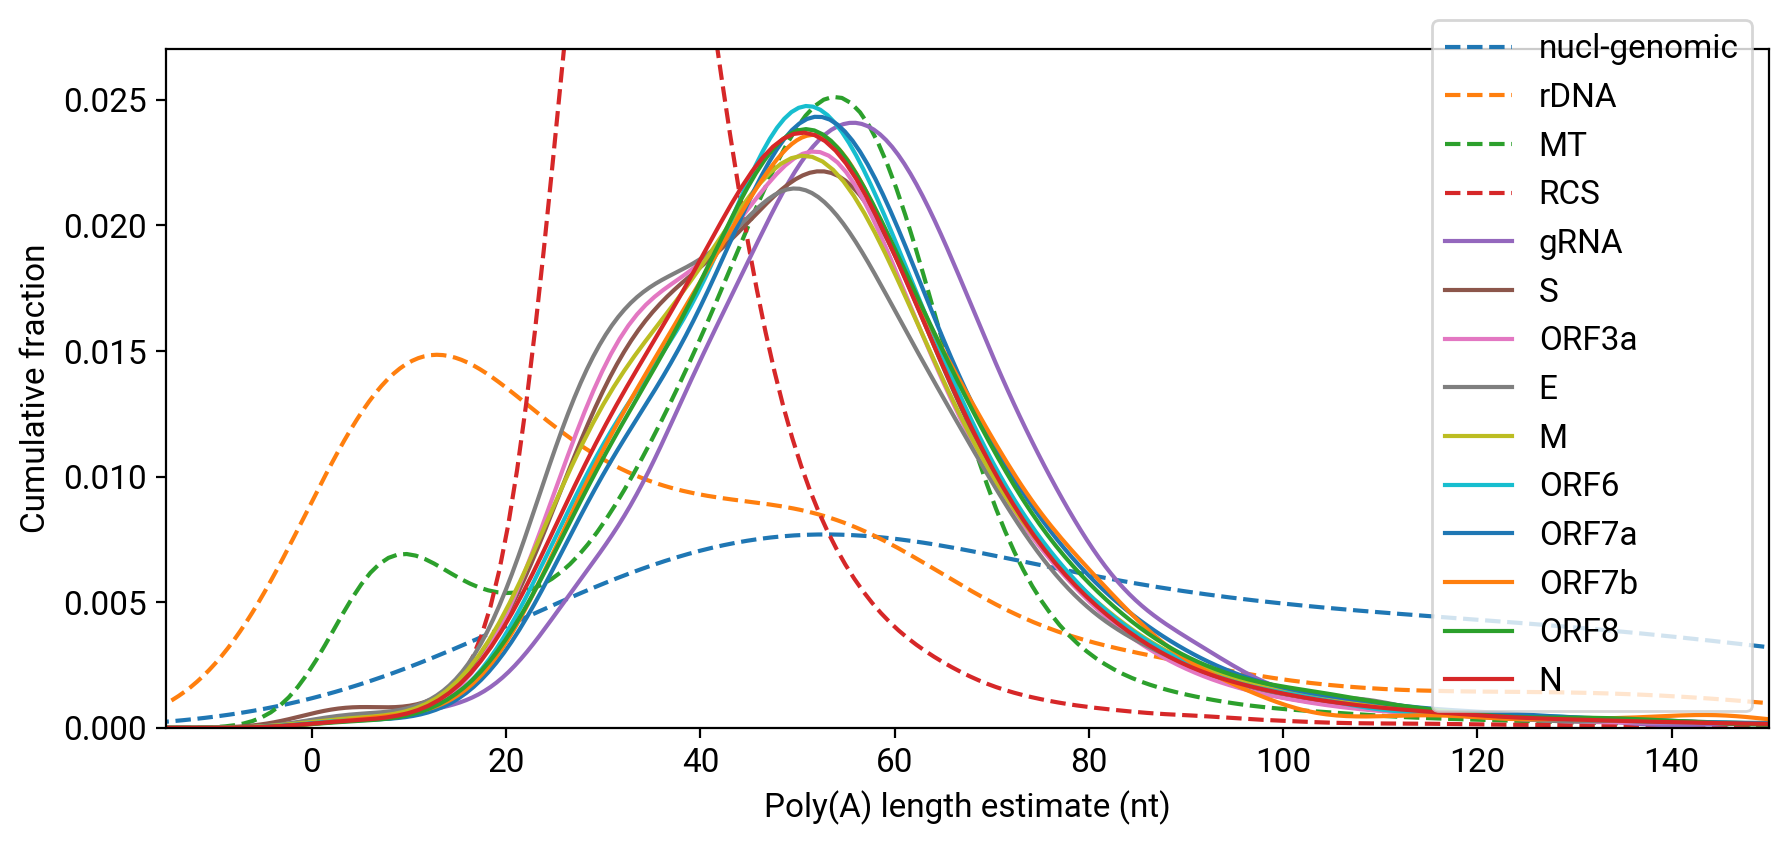

In [14]:

ORDER = 'genomic rDNA MT RCS gRNA S ORF3a E M ORF6 ORF7a ORF7b ORF8 N'.split()
groups = hNv_ppx.groupby('transcript')

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

for trname in ORDER:
    grp = hNv_ppx.loc[groups.groups[trname]]
    linestyle = '--' if trname in ['MT', 'RCS', 'genomic', 'rDNA'] else '-'
    if trname == 'genomic':
        trname = 'nucl-genomic'
    (grp['polya_dwell'].dropna() * 105).plot.kde(ax=ax, label=trname, bw_method=0.2, ls=linestyle)

plt.tight_layout()
ax.set_xlim(-15, 150)
ax.set_ylim(0, 0.027)
ax.legend(loc='best')
ax.set_xlabel('Poly(A) length estimate (nt)')
ax.set_ylabel('Cumulative fraction')

In [15]:
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

In [16]:
rcs_matches = hNv_ppx.loc[groups.groups['RCS']]
rcs_polya_dwells = rcs_matches.dropna(subset=['polya_dwell'])['polya_dwell']

95.75079872204473


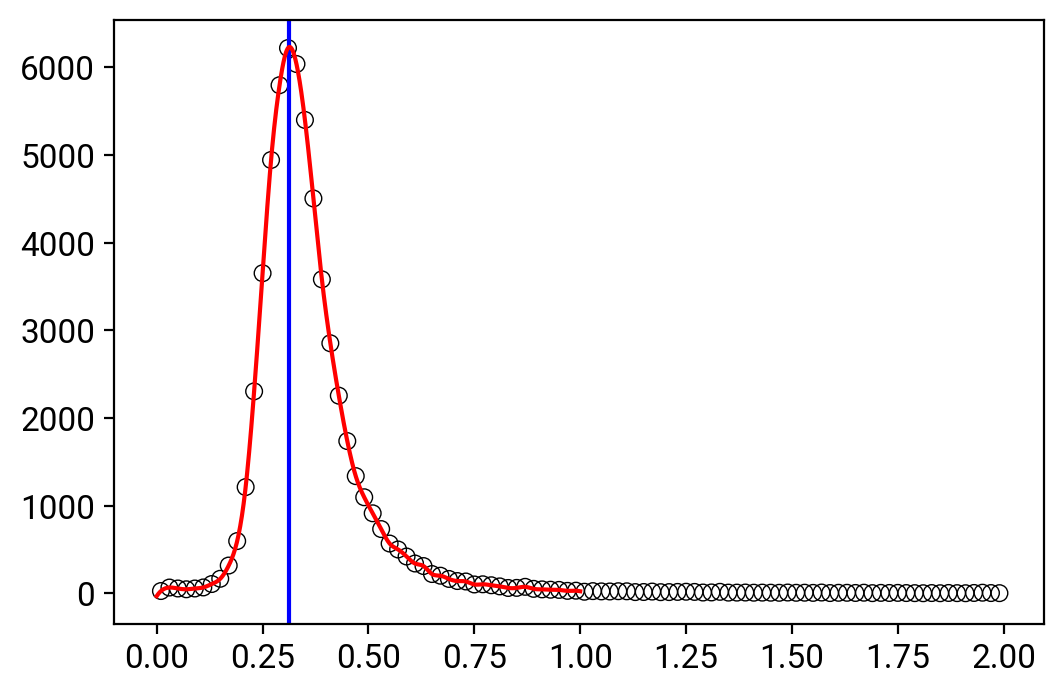

In [17]:
counts, edges = np.histogram(rcs_polya_dwells, bins=100, range=(0, 2))
centers = (edges[:-1] + edges[1:]) / 2
plt.scatter(centers, counts, fc='none', edgecolor='black', lw=.5)

csp = CubicSpline(centers, counts)
csp_x = np.linspace(0, 1, 1000)
csp_y = csp(csp_x)
peaks, promscore = find_peaks(csp_y, prominence=100)
assert len(peaks) == 1
plt.axvline(csp_x[peaks[0]], c='blue')
peakpoint = csp_x[peaks[0]]
plt.plot(csp_x, csp_y, c='red')
adjfactor = 30 / peakpoint
print(adjfactor)

In [18]:
viral_ppx = hNv_ppx[~hNv_ppx['transcript'].isin(['genomic', 'rDNA', 'MT', 'RCS'])]

In [19]:
viral_polya = viral_ppx['polya_dwell'].dropna() * adjfactor

In [20]:
np.percentile(viral_polya, [5, 10, 25, 50, 75, 90, 95])

array([23.55469649, 27.62410543, 36.58638019, 46.88916613, 57.47920447,
       70.89389137, 82.40313738])

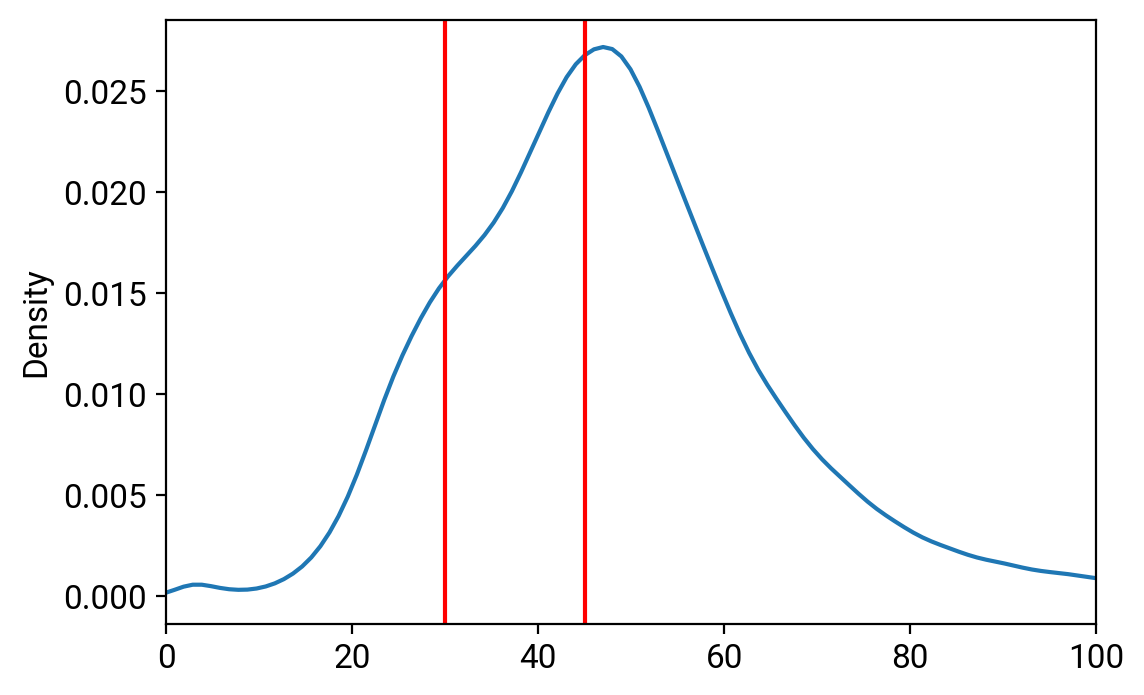

In [21]:
pd.Series(viral_polya).plot.kde()
plt.xlim(0, 100)
plt.axvline(30, c='red')
plt.axvline(45, c='red')

In [22]:
pAdist = {}
for grpname, grp in groups.groups.items():
    pAdist[grpname] = (hNv_ppx.loc[grp]['polya_dwell'].dropna() * adjfactor)

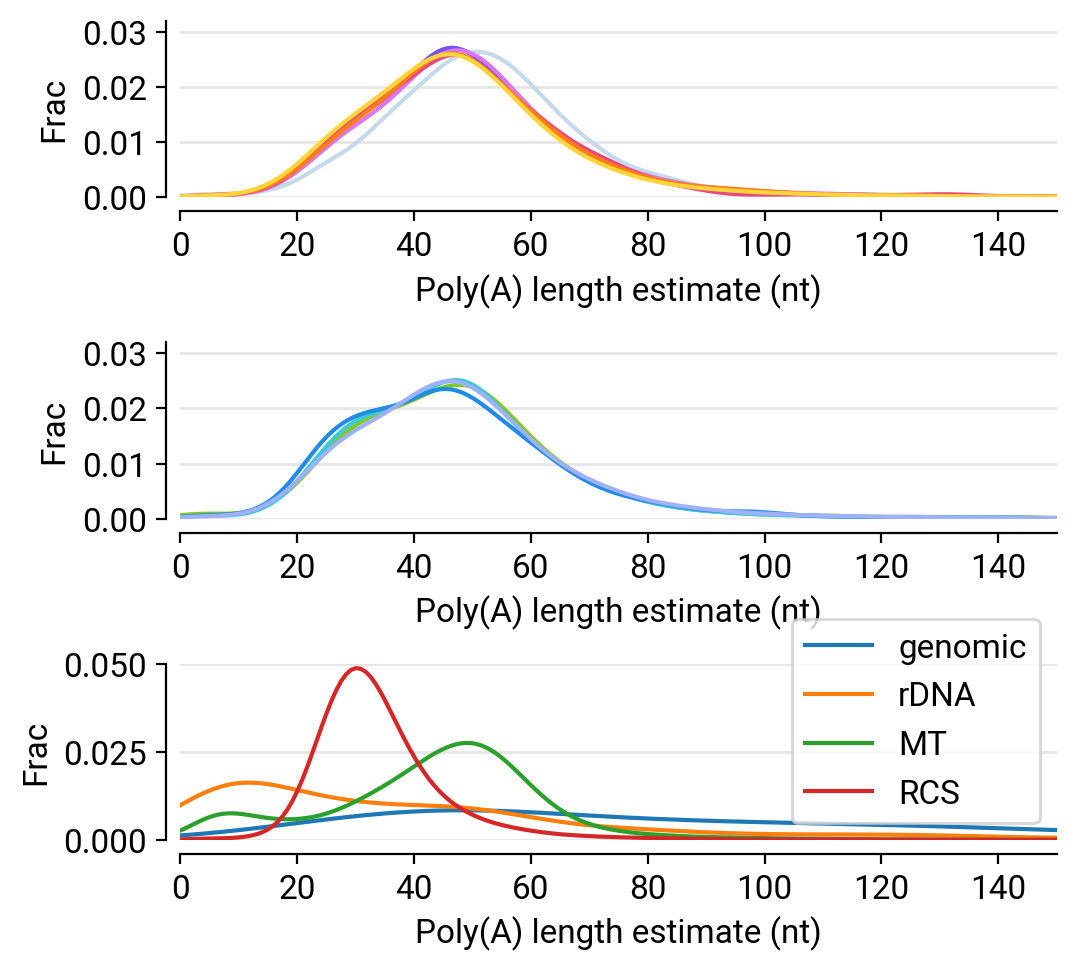

In [23]:
P1_ORDER = 'gRNA ORF6 ORF7a ORF7b ORF8 N'.split()
P2_ORDER = 'S ORF3a E M '.split()
P3_ORDER = 'genomic rDNA MT RCS'.split()
XRANGE = 0, 150

def common_tweaks(ax):
    ax.set_xlim(*XRANGE)
    ax.set_xlabel('Poly(A) length estimate (nt)')
    ax.set_ylabel('Frac')
    for sp in 'top right'.split():
        ax.spines[sp].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.yaxis.grid(True, c='black', alpha=.1, lw=1)

fig, axes = plt.subplots(3, 1, figsize=(5.44, 5))


ax = axes[0]

for trname in P1_ORDER:
    linestyle = '-'
    pAdist[trname].plot.kde(ax=ax, label=trname, c=orfcolors[trname], bw_method=0.2, ls=linestyle)

ax.set_ylim(0, 0.032)
common_tweaks(ax)
ax.set_yticks(np.arange(0.0, 0.031, 0.01))


ax = axes[1]

for trname in P2_ORDER:
    pAdist[trname].plot.kde(ax=ax, label=trname, bw_method=0.2, ls=linestyle, c=orfcolors[trname])
    linestyle = '-'

ax.set_ylim(0, 0.032)
common_tweaks(ax)
ax.set_yticks(np.arange(0.0, 0.031, 0.01))


ax = axes[2]

for trname in P3_ORDER:
    linestyle = '-'
    pAdist[trname].plot.kde(ax=ax, label=trname, bw_method=0.2, ls=linestyle)

ax.set_ylim(0, 0.05)
ax.legend(loc='best')
common_tweaks(ax)

plt.tight_layout()
plt.savefig('figure-outputs/plot-polya-overall.pdf')

# By methylation status

In [24]:
import h5py
READ_CHUNK_SIZE = 100000

def load_stats(orf, tgtpos):
    with h5py.File('basemod/flg-stats/' + orf + '-perread.tombo.per_read_stats', 'r') as f5:
        mgstats = []
        
        for block in f5['Statistic_Blocks'].values():
            blkstats = block['block_stats']

            tgtstats = []
            for start in range(0, len(blkstats), READ_CHUNK_SIZE):
                statsblk = pd.DataFrame(blkstats[start:start+READ_CHUNK_SIZE])
                tgtstats.append(statsblk[statsblk['pos'].isin(tgtpos)])

            tgtstats = pd.concat(tgtstats)
            read_ids = pd.DataFrame(block['read_ids'])
            read_id_vals = pd.DataFrame(block['read_id_vals'])
            read_ids = pd.DataFrame({
                'read_id': read_ids[0].apply(lambda x: x[2:-1]),
                'rno': read_id_vals[0],
            })
            tgtstats = pd.merge(read_ids, tgtstats, left_on='rno', right_on='read_id',
                                suffixes=['', '_no'])
            del tgtstats['read_id_no']
            
            mgstats.append(tgtstats)
            
        return pd.concat(mgstats).set_index('read_id')

In [25]:
ORFS = 'ORF1ab S ORF3a E M ORF6 ORF7a ORF7b ORF8 N'.split()
TARGET_SITES = np.array(list(map(int, """
6891 12788 13750 15948 17585 25357 25460 26058 26297 26731 27106 27165
27268 27305 27486 27948 28591 28612 28653 28669 28701 28789 28805 28860
28879 28898 28931 28949 28958 29016 29041 29088 29127 29155 29170 29298
29313 29378 29408 29444 29776""".split()))) - 1

In [26]:
methstatus = []

for orf in ORFS:
    print(orf)
    loaded = load_stats(orf, set(TARGET_SITES))
    loaded['orf'] = orf
    methstatus.append(loaded)

methstatus = pd.concat(methstatus)

ORF1ab
S
ORF3a
E
M
ORF6
ORF7a
ORF7b
ORF8
N


In [27]:
methstatus = methstatus.reset_index()
del methstatus['rno']
len(methstatus)

7821664

In [28]:
methstatus.to_pickle('stats/individual-read-site-basemod-status.pickle')

In [29]:
Nmethsites = np.array([28591, 28612, 28653, 28860, 28958, 29016, 29088, 29127]) - 1

In [30]:
modsites_Nmeth = methstatus[methstatus['pos'].isin(set(Nmethsites))]

In [31]:
del methstatus

In [32]:
modsites_Nmeth

,read_id,pos,stat,orf
669,9de4d519-c48f-48c5-a412-31be405f5ec5,28590,0.788853,ORF1ab
670,9de4d519-c48f-48c5-a412-31be405f5ec5,28611,0.963129,ORF1ab
671,9de4d519-c48f-48c5-a412-31be405f5ec5,28652,0.931294,ORF1ab
676,9de4d519-c48f-48c5-a412-31be405f5ec5,28859,0.021485,ORF1ab
681,9de4d519-c48f-48c5-a412-31be405f5ec5,28957,0.533626,ORF1ab
...,...,...,...,...
7821646,29a92c92-c857-4947-9126-9cad44bca1d7,28859,0.758872,N
7821651,29a92c92-c857-4947-9126-9cad44bca1d7,28957,0.726286,N
7821652,29a92c92-c857-4947-9126-9cad44bca1d7,29015,0.628123,N
7821654,29a92c92-c857-4947-9126-9cad44bca1d7,29087,0.917073,N


In [33]:
modsites_Nmeth = modsites_Nmeth.copy()
modsites_Nmeth['modified'] = modsites_Nmeth['stat'] < 0.01
methratio = modsites_Nmeth.groupby('read_id').agg({'orf': 'first', 'modified': 'mean'})

In [34]:
8*0.3

2.4

(array([1.34049e+05, 6.39640e+04, 3.80670e+04, 2.22960e+04, 4.70000e+01,
        1.05000e+04, 3.94000e+03, 1.05100e+03, 2.48000e+02, 8.60000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

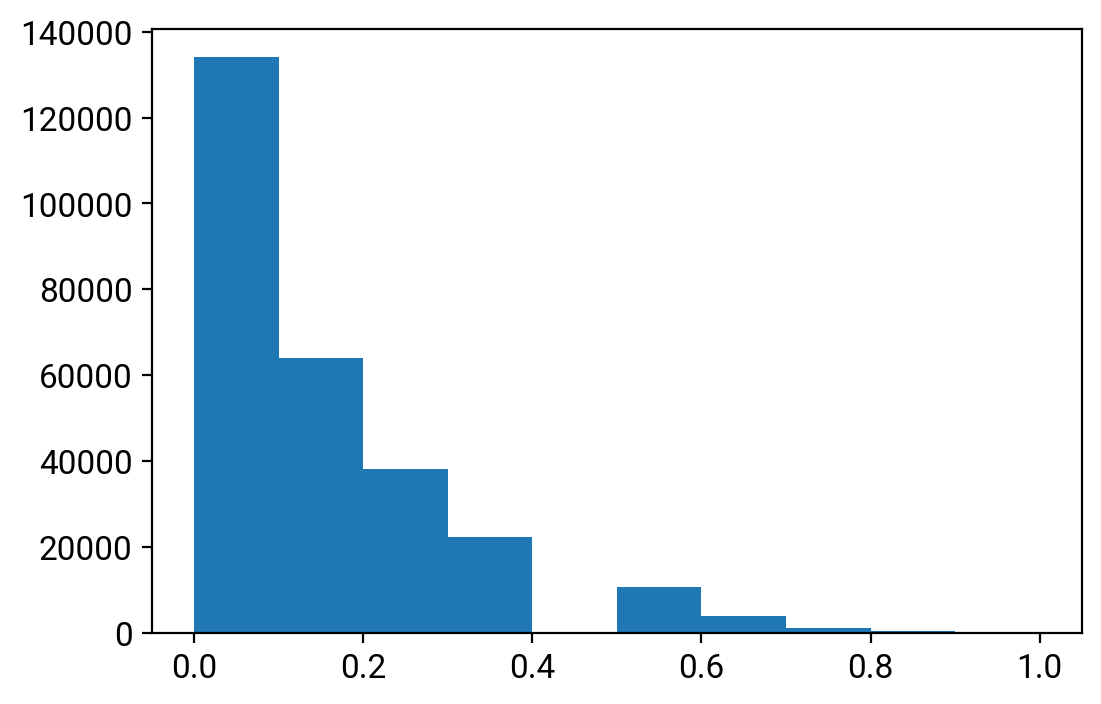

In [35]:
plt.hist(methratio['modified'])

In [36]:
highly_modified = methratio[methratio['modified'] >= 0.3]
not_modified = methratio[methratio['modified'] < 0.05]
len(highly_modified), len(not_modified)

(38168, 134049)

In [37]:
orfcolors['ORF1ab'] = '#303030'

ORF1ab
S


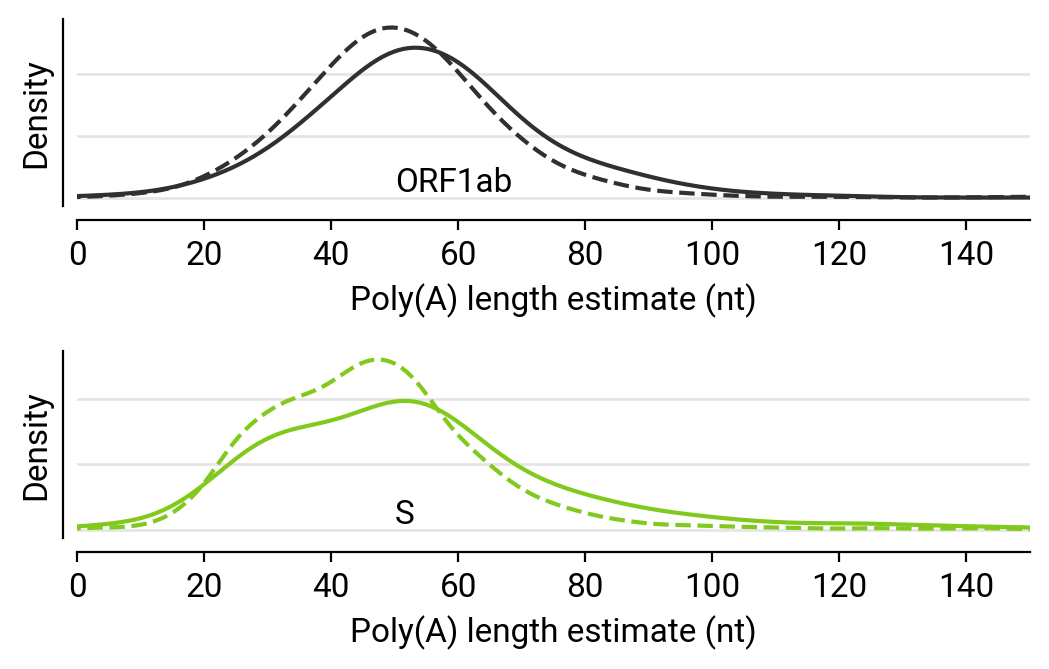

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(5.4, 3.5))

for orfname, ax in zip('ORF1ab S'.split(), axes):
    print(orfname)
    reads = highly_modified[highly_modified['orf'] == orfname]
    ppxmg = pd.merge(reads, ppx, left_index=True, right_on='read_id')
    polya_lengths = ppxmg['polya_dwell'].dropna() * adjfactor
    pd.Series(polya_lengths).plot.kde(label='Modified', ax=ax, c=orfcolors[orfname], ls='--')
    
    reads_not = not_modified[not_modified['orf'] == orfname]
    ppxmg_not = pd.merge(reads_not, ppx, left_index=True, right_on='read_id')
    polya_lengths_not = ppxmg_not['polya_dwell'].dropna() * adjfactor
    pd.Series(polya_lengths_not).plot.kde(label='Not modified', ax=ax, c=orfcolors[orfname])
    
    ax.annotate(orfname, (50, 0.001))
    ax.set_xlim(0, 150)
    ax.set_xlabel('Poly(A) length estimate (nt)')
    ax.yaxis.grid(True, lw=1, alpha=.3, c='black')
    ax.set_xlim(*XRANGE)
    for sp in 'top right'.split():
        ax.spines[sp].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.yaxis.grid(True, c='black', alpha=.1, lw=1)
    
    if orfname == 'ORF1ab':
        ax.set_yticks(np.arange(0, 0.03, 0.01))
    else:
        ax.set_yticks(np.arange(0, 0.03, 0.01))

    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_yticklines(), visible=False)

plt.tight_layout()
plt.savefig('figure-outputs/plot-modrate-polyA-mainfig.pdf')

Statistical test

In [48]:
%load_ext rpy2.ipython

/blaze/hyeshik/conda/envs/lab/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [64]:
def test_mod_polya(orfname):
    reads_high = highly_modified[highly_modified['orf'] == orfname]
    reads_not = not_modified[not_modified['orf'] == orfname]
    
    ppxmg = pd.merge(reads_high, ppx, left_index=True, right_on='read_id')
    polya_lengths_high = ppxmg['polya_dwell'].dropna() * adjfactor
    ppxmg = pd.merge(reads_not, ppx, left_index=True, right_on='read_id')
    polya_lengths_not = ppxmg['polya_dwell'].dropna() * adjfactor

    rst = %R -i polya_lengths_high -i polya_lengths_not wilcox.test(polya_lengths_high, polya_lengths_not, alternative='less')$p.value
    return rst[0]

test_mod_polya('S')

7.271935065893657e-12

In [65]:
test_mod_polya('ORF1ab')

9.827959561227714e-05

ORF3a
E
M
ORF6
ORF7a
ORF7b
ORF8
N


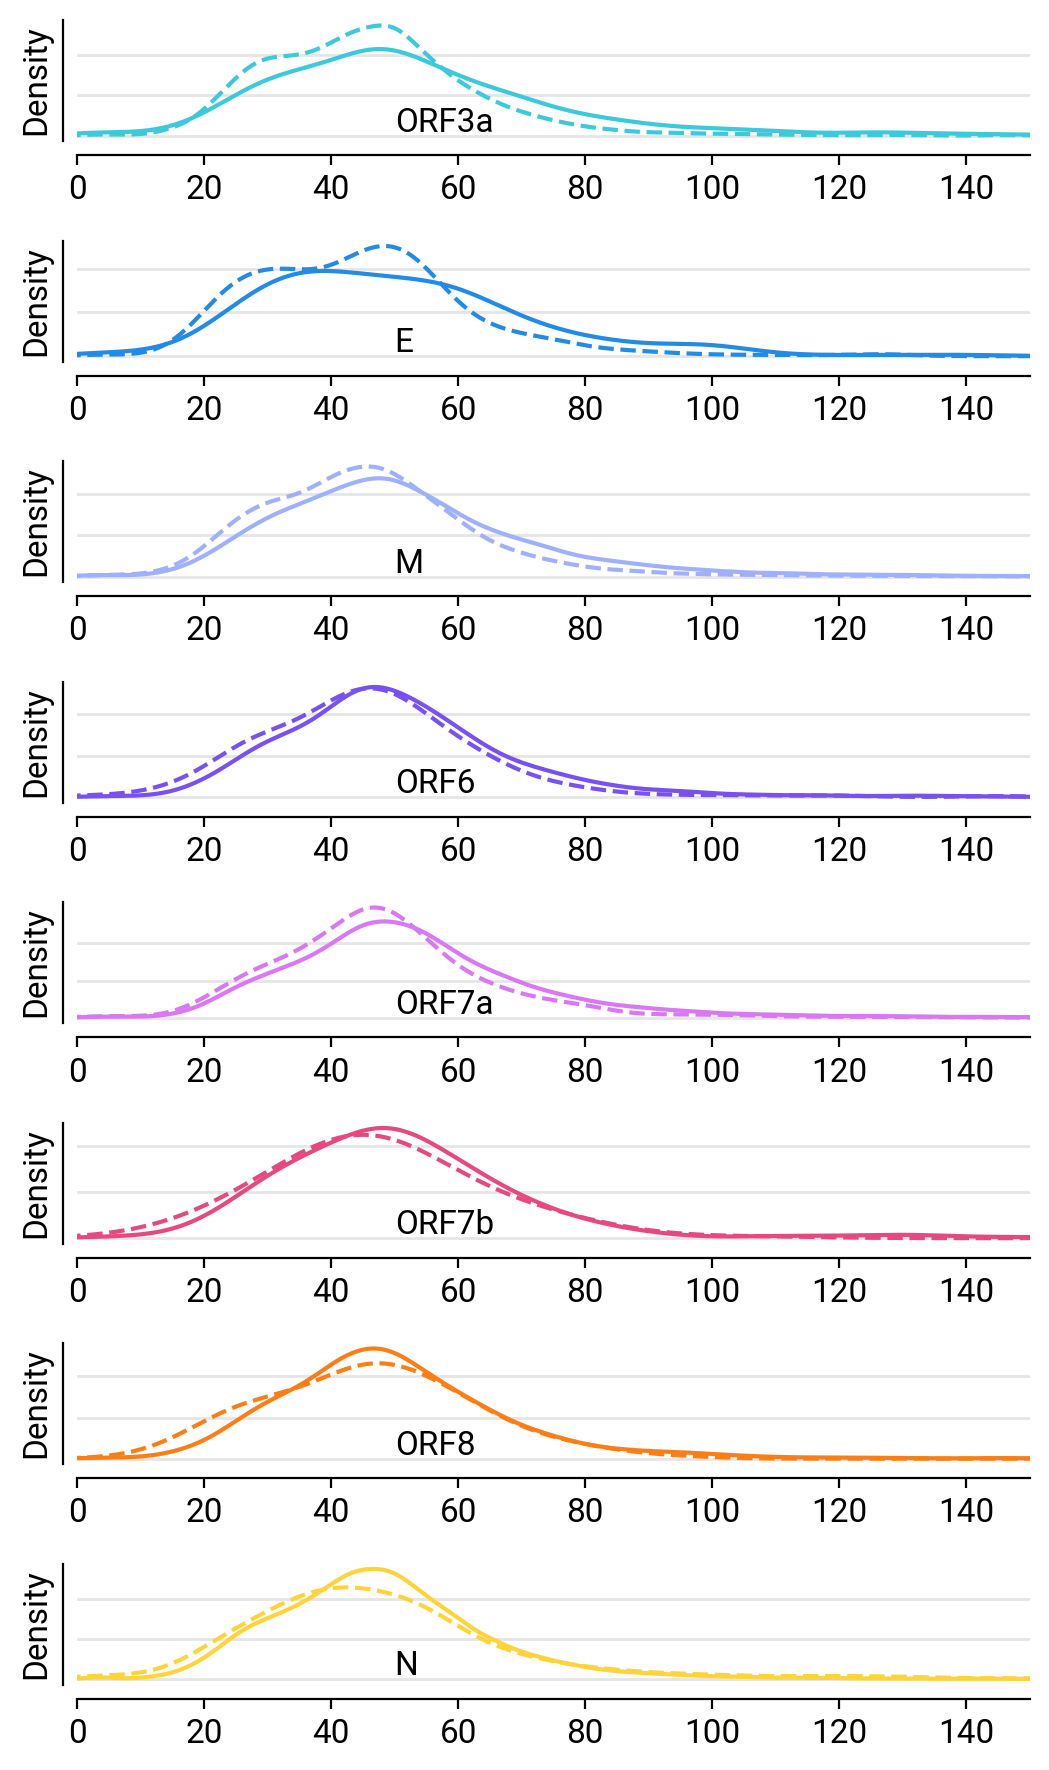

In [39]:
fig, axes = plt.subplots(8, 1, figsize=(5.4, 9))

for orfname, ax in zip('ORF3a E M ORF6 ORF7a ORF7b ORF8 N'.split(), axes):
    print(orfname)
    reads = highly_modified[highly_modified['orf'] == orfname]
    ppxmg = pd.merge(reads, ppx, left_index=True, right_on='read_id')
    polya_lengths = ppxmg['polya_dwell'].dropna() * adjfactor
    pd.Series(polya_lengths).plot.kde(label='Modified', ax=ax, c=orfcolors[orfname], ls='--')
    
    reads_not = not_modified[not_modified['orf'] == orfname]
    ppxmg_not = pd.merge(reads_not, ppx, left_index=True, right_on='read_id')
    polya_lengths_not = ppxmg_not['polya_dwell'].dropna() * adjfactor
    pd.Series(polya_lengths_not).plot.kde(label='Not modified', ax=ax, c=orfcolors[orfname])
    
    ax.annotate(orfname, (50, 0.001))
    ax.set_xlim(0, 150)
    ax.yaxis.grid(True, lw=1, alpha=.3, c='black')
    ax.set_xlim(*XRANGE)
    for sp in 'top right'.split():
        ax.spines[sp].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.yaxis.grid(True, c='black', alpha=.1, lw=1)
    
    if orfname == 'ORF1ab':
        ax.set_yticks(np.arange(0, 0.03, 0.01))
    else:
        ax.set_yticks(np.arange(0, 0.03, 0.01))

    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_yticklines(), visible=False)

plt.tight_layout()
plt.savefig('figure-outputs/plot-modification-polya-supl.pdf')